# gridded_data_tutorial
## Notebook 3: DayMet
Waterhackweek 2020
Steven Pestana (spestana@uw.edu)
***

By the end of this notebook you will be able to:
* Access DayMet with xarray, understand its data structure and components
* Select subsets of DayMet in time and space
* Plot DayMet with xarray

---


## What is DayMet?

</br></br>

<div align="left" style="display:inline-block;float:left;width:50%;">

* Gridded daily data at 1 km resolution
* Spatial: North America, Hawaii, Puerto Rico
* Lambert Conformal Conic
* Data is hosted by the [Oak Ridge National Lab DAAC](https://daymet.ornl.gov/)
* Access methods web portal, ulmo, [daymetpy](bluegreen-labs.github.io/daymetpy), OPeNDAP Application Programming Interface (API)

We will be using:

**Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 3**
* [User Guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)
* [Recent article about Daymet](https://earthdata.nasa.gov/learn/articles/daymet-and-daymet-2019-data)
* ...



</div>



<div align="right" style="display:inline-block;float:right;width:50%;">

<img src="https://cdn.earthdata.nasa.gov/conduit/upload/14259/DEM_HorizonFiles_2010stns_crop-resize_continent-only.jpg" style="height:300px;align:center;">

</div>

### How can we access this data? 

using [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) (Open-source Project for a Network Data Access Protocol)

* show how to search and select DayMet data using the OPeNDAP endpoint

https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328

https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml.html

https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html?dataset=daymet-v3-agg/na.ncml

https://thredds.daac.ornl.gov/thredds-daymet/catalog/daymet-v3-agg/catalog.html

In [61]:
import xarray as xr
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import box, Point

import matplotlib.pyplot as plt
%matplotlib inline

**OPeNDAP endpoints for DayMet:**

what data can we get and how do we select it?

In [62]:
ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")

**What did we just open with xarray? Look at the dataset's structure and metadata:**

* *Dimensions* of **time**, **x**, and **y**
* *Coordinates* of **time**, **x**, **y**, **lat**, and **lon**
* *Data variables*
* *Attributes*



In [63]:
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

**Look at a single data variable and its metadata:**

In [64]:
ds.prcp

<xarray.DataArray 'prcp' (time: 14600, y: 8075, x: 7814)>
[921231530000 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4560250.0 -4559250.0 ... 3251750.0 3252750.0
  * y        (y) float32 4984000.0 4983000.0 4982000.0 ... -3089000.0 -3090000.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

**What coordinate reference system does DayMet use?**

In [65]:
ds.lambert_conformal_conic.attrs

{'grid_mapping_name': 'lambert_conformal_conic',
 'longitude_of_central_meridian': -100.0,
 'latitude_of_projection_origin': 42.5,
 'false_easting': 0.0,
 'false_northing': 0.0,
 'standard_parallel': array([25., 60.]),
 'semi_major_axis': 6378137.0,
 'inverse_flattening': 298.257223563,
 'longitude_of_prime_meridian': 0.0}

This gives us all the information we need to define the coordinate ystem, and therefore transform other coordinates into or out of this coordinate space.

(Note that the `semi_major_axis`, `inverse_flattening`, and `longitude_of_prime_meridian` correspond to the [WGS84 Ellipsoid](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84).)


**We now know what the data structure is and what the metadata tells us!**

---
**Now we are going to subset the DayMet data to a smaller area to work with.** This Dataset contains a lot of information, which will take a long time to load if we tried to look at everything at once.

Let's start by selecting a region around Washington state and then make some plots looking at a single day.

To start, we can define a bounding box in Longitude and Latitude coordinates using [geopandas](https://geopandas.org/) and [shapely](https://shapely.readthedocs.io/en/latest/manual.html).

In [66]:
# Specify the region we want to look at with DayMet (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)
bounding_box = gpd.GeoSeries(box(-125.0, 45.5, -117.0, 49.0), crs='epsg:4326')

**We next need to transform these coordinates into the Lambert Conformal Conic coordinate system used by DayMet.** Here we will use [pyproj](https://pyproj4.github.io/pyproj/stable/) to read DayMet's coordinate reference system and convert it into a format we can use.

In [102]:
# Get the coordinate reference system used by DayMet
daymet_crs = CRS.from_cf(ds.lambert_conformal_conic.attrs)

In [105]:
# Reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
bounding_box = bounding_box.to_crs(daymet_crs)

In [106]:
# Take a look at our bounding box object
bounding_box

0    POLYGON ((-1258946.566 446607.700, -1183671.05...
dtype: geometry

In [107]:
# Now we can get our bounds out in this coordinate system using
bounding_box.bounds

# These can be accessed indiviudally as for example:
# bounding_box.bounds.minx[0]
# where [0] cooresponds to our first and only row

,minx,miny,maxx,maxy
0,-1.836486e+06,446607.699546,-1.183671e+06,950503.83288


**Now use the bounds to slice the DayMet dataset in the x and y dimensions to select the Washington area.**

In [68]:
# Select this region from our DayMet Dataset
washington = ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]), # Here we are slicing the x axis with slice(minx, maxx)
                   y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0])) # Note that we are slicing the *inverted* y axis with slice(maxy,miny)

# Look at what we selected from DayMet
washington

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 653, y: 504)
Coordinates:
  * x                        (x) float32 -1836250.0 -1835250.0 ... -1184250.0
  * y                        (y) float32 950000.0 949000.0 ... 448000.0 447000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2020-01-01
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

**What does this look like now?** Plot tmax for the first day:

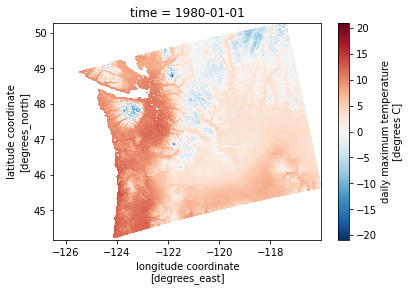

In [89]:
washington.tmax.isel(time=0).plot(x='lon', y='lat')

# Note that this is equivalent to:
# washington.tmax[0].plot(x='lon', y='lat')

---

**We can also try selecting in time and space dimensions.** 

Here let's look at SWE for a single water year (October 2016 - September 2017) for a point near Mt. Rainier.

In [112]:
# Define a point with Longitude and Latitude (EPSG:4326)
my_point_lon_lat = gpd.GeoSeries(Point(-121.6, 46.9), crs='epsg:4326')

# Convert to the DayMet coordinate reference system as we did previously with our bounding box
my_point = my_point_lon_lat.to_crs(daymet_crs)

**xarray allows us to stack multiple methods in a single expression.** 

Here we have two `.sel()` methods applied to the `ds.swe` DataArray. The first selects a time slice, the second selects x and y coordinates for our point.

Using `method='nearest'` means that it'll find the x and y coordinates nearest to what we provide with `my_point.x` and `my_point.y`

In [109]:
# Select from DayMet SWE a time slice and an x and y point using the 'nearest' method
my_point_swe = washington.swe.sel(time=slice('10-2016','9-2017')).sel(x=my_point.x[0], y=my_point.y[0], method='nearest')

In [110]:
# Look at the result
my_point_swe

<xarray.DataArray 'swe' (time: 364)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    x        float32 -1554250.0
    y        float32 669000.0
  * time     (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2017-09-30
    lat      float32 ...
    lon      float32 ...
Attributes:
    long_name:     snow water equivalent
    units:         kg/m2
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: mean

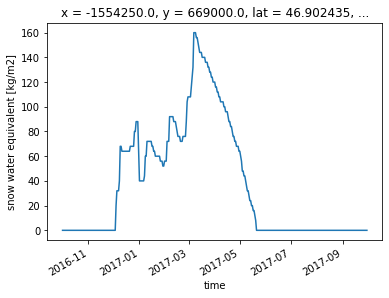

In [95]:
# Plot SWE at this point
my_point_swe.plot()

(46.5, 47.2)

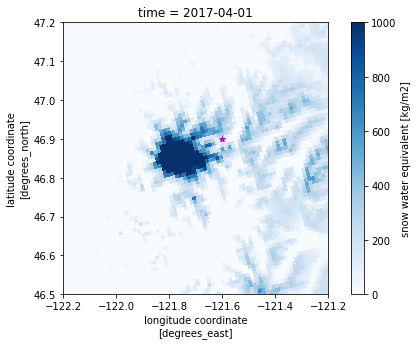

In [136]:
# Plot a map showing where our point is
fig, ax = plt.subplots(figsize=(8,5))

# Plot a map of SWE for April 1st 2017
washington.swe.sel(time='4-1-2017').plot(x='lon', y='lat', cmap='Blues', ax=ax)

# Plot our point
my_point_lon_lat.plot(ax=ax, color='m', marker='*')

# set axes limits
ax.set_xlim([-122.2,-121.2])
ax.set_ylim([46.5,47.2])




---